#Question Definition
As a football analyst at Mchezopesa Ltd I am to predict the probability of a win, loss or draw and predict the number of goals the hometeam is likelt to score using two datasets; fifa_ranking.csv and results.csv.

**Methods**
* Polynormial regression
* Logistic regression

#Metrics for Success
1. Two polynormial regression models that predicts goals scored by home team and another than predicts goals scored by away team and both with RMSEs of less than 1.
2. A logistic model that predicts wins, losses and draw with high accuracy.

#Importing libraries


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats #For z test Calculation
from statsmodels.stats import weightstats as stests #For z test calculation
import pandas_profiling as pp
from statistics import mean  #For mean calculation
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

#Loading dataset

In [500]:
#loading the ranking dataset
ranking=pd.read_csv('fifa_ranking.csv')
ranking.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [501]:
#loading the results dataset
results=pd.read_csv('results.csv')
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


#Data preparation

In [502]:
#displaying the columns in the dataset
print(results.columns)
print(ranking.columns)

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral'],
      dtype='object')
Index(['rank', 'country_full', 'country_abrv', 'total_points',
       'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted', 'confederation', 'rank_date'],
      dtype='object')


In [503]:
#renaming the columns
ranking.columns=map(str.lower, ranking.columns)


columns= ['rank', 'country', 'country_abrv', 'total_points',
       'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted', 'confederation', 'rank_date']      
ranking.columns=columns
ranking.head()

,rank,country,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [504]:
#Determining the shape of our datasets
def df_shape(a,b):
  print(a.shape)
  print(b.shape)

df_shape(ranking, results)

(57793, 16)
(40839, 9)


In [0]:
ranking.drop(columns=['cur_year_avg', 'cur_year_avg_weighted',
       'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg',
       'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted', 'confederation', 'country_abrv'], inplace=True)

In [0]:
#changing the rank date column to datetime datatype then splitting into month and year


ranking.rank_date = ranking.rank_date.apply(lambda x: x.replace('/', '-'))

ranking.rank_date = pd.to_datetime(ranking.rank_date)

ranking['year'] = ranking.rank_date.dt.year

ranking['month'] = ranking.rank_date.dt.month

In [507]:
#checking if the datatype change and column split was succefull
ranking.head()

,rank,country,total_points,previous_points,rank_change,rank_date,year,month
0,1,Germany,0.0,57,0,1993-08-08,1993,8
1,2,Italy,0.0,57,0,1993-08-08,1993,8
2,3,Switzerland,0.0,50,9,1993-08-08,1993,8
3,4,Sweden,0.0,55,0,1993-08-08,1993,8
4,5,Argentina,0.0,51,5,1993-08-08,1993,8


In [0]:
#changing the rank date column to datetime then splitting into month and year on the results
# dataset


results.date = results.date.apply(lambda x: x.replace('/', '-'))

results.date = pd.to_datetime(results.date)

results['year'] = results.date.dt.year

results['month'] = results.date.dt.month

In [509]:
#removing data from the years before 1993 because the fifa ranking data starts from 1993
results= results[results['date']>='1993']
#confirming the data only has data from 1993
results['year'].min()

1993

In [510]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month
17361,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,1993,1
17362,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,1993,1
17363,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False,1993,1
17364,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,1993,1
17365,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,1993,1


In [511]:
#checking shape of results dataframe
results.shape

(23478, 11)

#Merging of datasets

In [512]:

#merging the ranking and results dataset to get the merged_home dataset
merged_home=pd.merge(ranking, results, how='inner', left_on = ['year', 'month','country'], right_on = ['year', 'month','home_team'])
merged_home.head()

,rank,country_x,total_points,previous_points,rank_change,rank_date,year,month,date,home_team,away_team,home_score,away_score,tournament,city,country_y,neutral
0,4,Sweden,0.0,55,0,1993-08-08,1993,8,1993-08-11,Sweden,Switzerland,1,2,Friendly,Borås,Sweden,False
1,4,Sweden,0.0,55,0,1993-08-08,1993,8,1993-08-22,Sweden,France,1,1,FIFA World Cup qualification,Solna,Sweden,False
2,5,Argentina,0.0,51,5,1993-08-08,1993,8,1993-08-22,Argentina,Peru,2,1,FIFA World Cup qualification,Buenos Aires,Argentina,False
3,5,Argentina,0.0,51,5,1993-08-08,1993,8,1993-08-29,Argentina,Paraguay,0,0,FIFA World Cup qualification,Buenos Aires,Argentina,False
4,8,Brazil,0.0,55,-5,1993-08-08,1993,8,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False


In [0]:
#dropping irrelevant columns and renaming some columns
merged_home.drop(columns=['country_y','rank_date','city','date'], inplace=True)


In [0]:
#Renaming the columns to names that are easier to use
merged_home.country_x=merged_home.rename({'country_x':'country','rank':'rank_home'}, axis = 1, inplace = True)

In [515]:
merged_home.head()

,rank_home,country,total_points,previous_points,rank_change,year,month,home_team,away_team,home_score,away_score,tournament,neutral
0,4,Sweden,0.0,55,0,1993,8,Sweden,Switzerland,1,2,Friendly,False
1,4,Sweden,0.0,55,0,1993,8,Sweden,France,1,1,FIFA World Cup qualification,False
2,5,Argentina,0.0,51,5,1993,8,Argentina,Peru,2,1,FIFA World Cup qualification,False
3,5,Argentina,0.0,51,5,1993,8,Argentina,Paraguay,0,0,FIFA World Cup qualification,False
4,8,Brazil,0.0,55,-5,1993,8,Brazil,Mexico,1,1,Friendly,False


In [516]:

#merging the ranking and results dataset to get the merged_away dataset
merged_away=pd.merge(ranking, results, how='inner', left_on = ['year', 'month','country'], right_on = ['year', 'month','away_team'])
merged_away.head()

,rank,country_x,total_points,previous_points,rank_change,rank_date,year,month,date,home_team,away_team,home_score,away_score,tournament,city,country_y,neutral
0,3,Switzerland,0.0,50,9,1993-08-08,1993,8,1993-08-11,Sweden,Switzerland,1,2,Friendly,Borås,Sweden,False
1,5,Argentina,0.0,51,5,1993-08-08,1993,8,1993-08-01,Peru,Argentina,0,1,FIFA World Cup qualification,Lima,Peru,False
2,5,Argentina,0.0,51,5,1993-08-08,1993,8,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False
3,5,Argentina,0.0,51,5,1993-08-08,1993,8,1993-08-15,Colombia,Argentina,2,1,FIFA World Cup qualification,Barranquilla,Colombia,False
4,8,Brazil,0.0,55,-5,1993-08-08,1993,8,1993-08-01,Venezuela,Brazil,1,5,FIFA World Cup qualification,San Cristóbal,Venezuela,False


In [0]:
#removing unnecessary columns from the dataset
merged_away.drop(columns=['country_y','rank_date','date'], inplace=True)

In [0]:
merged_home.country_x=merged_away.rename({'country_x':'country','rank':'rank_away'}, axis = 1, inplace = True)

In [519]:
merged_away.head()

,rank_away,country,total_points,previous_points,rank_change,year,month,home_team,away_team,home_score,away_score,tournament,city,neutral
0,3,Switzerland,0.0,50,9,1993,8,Sweden,Switzerland,1,2,Friendly,Borås,False
1,5,Argentina,0.0,51,5,1993,8,Peru,Argentina,0,1,FIFA World Cup qualification,Lima,False
2,5,Argentina,0.0,51,5,1993,8,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,False
3,5,Argentina,0.0,51,5,1993,8,Colombia,Argentina,2,1,FIFA World Cup qualification,Barranquilla,False
4,8,Brazil,0.0,55,-5,1993,8,Venezuela,Brazil,1,5,FIFA World Cup qualification,San Cristóbal,False


In [520]:
#creating a subset of the merged_away dataframe
merged_away = merged_away[['rank_away','away_team','month','year']]

merged_away.head()

,rank_away,away_team,month,year
0,3,Switzerland,8,1993
1,5,Argentina,8,1993
2,5,Argentina,8,1993
3,5,Argentina,8,1993
4,8,Brazil,8,1993


In [521]:
#merging the merged_home and merged_away dtasets to get the merged_df dataset
merged_df = pd.merge( merged_home, merged_away, how = 'inner', left_on = ['year', 'month','away_team'], right_on = ['year', 'month','away_team'])
merged_df.head()

,rank_home,country,total_points,previous_points,rank_change,year,month,home_team,away_team,home_score,away_score,tournament,neutral,rank_away
0,4,Sweden,0.0,55,0,1993,8,Sweden,Switzerland,1,2,Friendly,False,3
1,4,Sweden,0.0,55,0,1993,8,Sweden,France,1,1,FIFA World Cup qualification,False,12
2,5,Argentina,0.0,51,5,1993,8,Argentina,Peru,2,1,FIFA World Cup qualification,False,70
3,5,Argentina,0.0,51,5,1993,8,Argentina,Peru,2,1,FIFA World Cup qualification,False,70
4,5,Argentina,0.0,51,5,1993,8,Argentina,Peru,2,1,FIFA World Cup qualification,False,70


In [522]:
print(merged_df.columns)

Index(['rank_home', 'country', 'total_points', 'previous_points',
       'rank_change', 'year', 'month', 'home_team', 'away_team', 'home_score',
       'away_score', 'tournament', 'neutral', 'rank_away'],
      dtype='object')


#Data understanding

In [523]:
#checking for missing values
merged_df.isnull().sum()

rank_home          0
country            0
total_points       0
previous_points    0
rank_change        0
year               0
month              0
home_team          0
away_team          0
home_score         0
away_score         0
tournament         0
neutral            0
rank_away          0
dtype: int64

There are no null values in our dataset

In [524]:
#chceking for duplicated values
merged_df.duplicated().sum()

11650

In [0]:
#dropping duplicates
merged_df.drop_duplicates(keep='first', inplace = True)

In [526]:
#checking the shape of the new dataset
merged_df.shape


(16868, 14)

In [527]:
#Determining the datatype of the columns in the dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16868 entries, 0 to 28517
Data columns (total 14 columns):
rank_home          16868 non-null int64
country            16868 non-null object
total_points       16868 non-null float64
previous_points    16868 non-null int64
rank_change        16868 non-null int64
year               16868 non-null int64
month              16868 non-null int64
home_team          16868 non-null object
away_team          16868 non-null object
home_score         16868 non-null int64
away_score         16868 non-null int64
tournament         16868 non-null object
neutral            16868 non-null bool
rank_away          16868 non-null int64
dtypes: bool(1), float64(1), int64(8), object(4)
memory usage: 1.8+ MB


There are 4 columns with string type data while the the rest are numerical except for one boolean

#Exploratory data analysis

#Univariate Analysis

In [528]:
#Checking the statistical distribution
merged_df.describe()

,rank_home,total_points,previous_points,rank_change,year,month,home_score,away_score,rank_away
count,16868.000000,16868.00000,16868.000000,16868.000000,16868.000000,16868.000000,16868.000000,16868.000000,16868.000000
mean,76.029049,166.06225,435.375978,0.933187,2006.499229,6.879120,1.604577,1.069481,78.852857
std,50.847921,313.82347,319.345652,6.849238,6.803159,3.272115,1.615800,1.245816,52.006329
min,1.000000,0.00000,0.000000,-62.000000,1993.000000,1.000000,0.000000,0.000000,1.000000
25%,33.000000,0.00000,174.000000,-2.000000,2001.000000,4.000000,0.000000,0.000000,35.000000
50%,70.000000,0.00000,417.000000,0.000000,2007.000000,7.000000,1.000000,1.000000,72.000000
75%,112.000000,230.81250,618.000000,3.000000,2012.000000,10.000000,2.000000,2.000000,115.000000
max,209.000000,1770.06000,1887.000000,73.000000,2018.000000,12.000000,31.000000,15.000000,209.000000


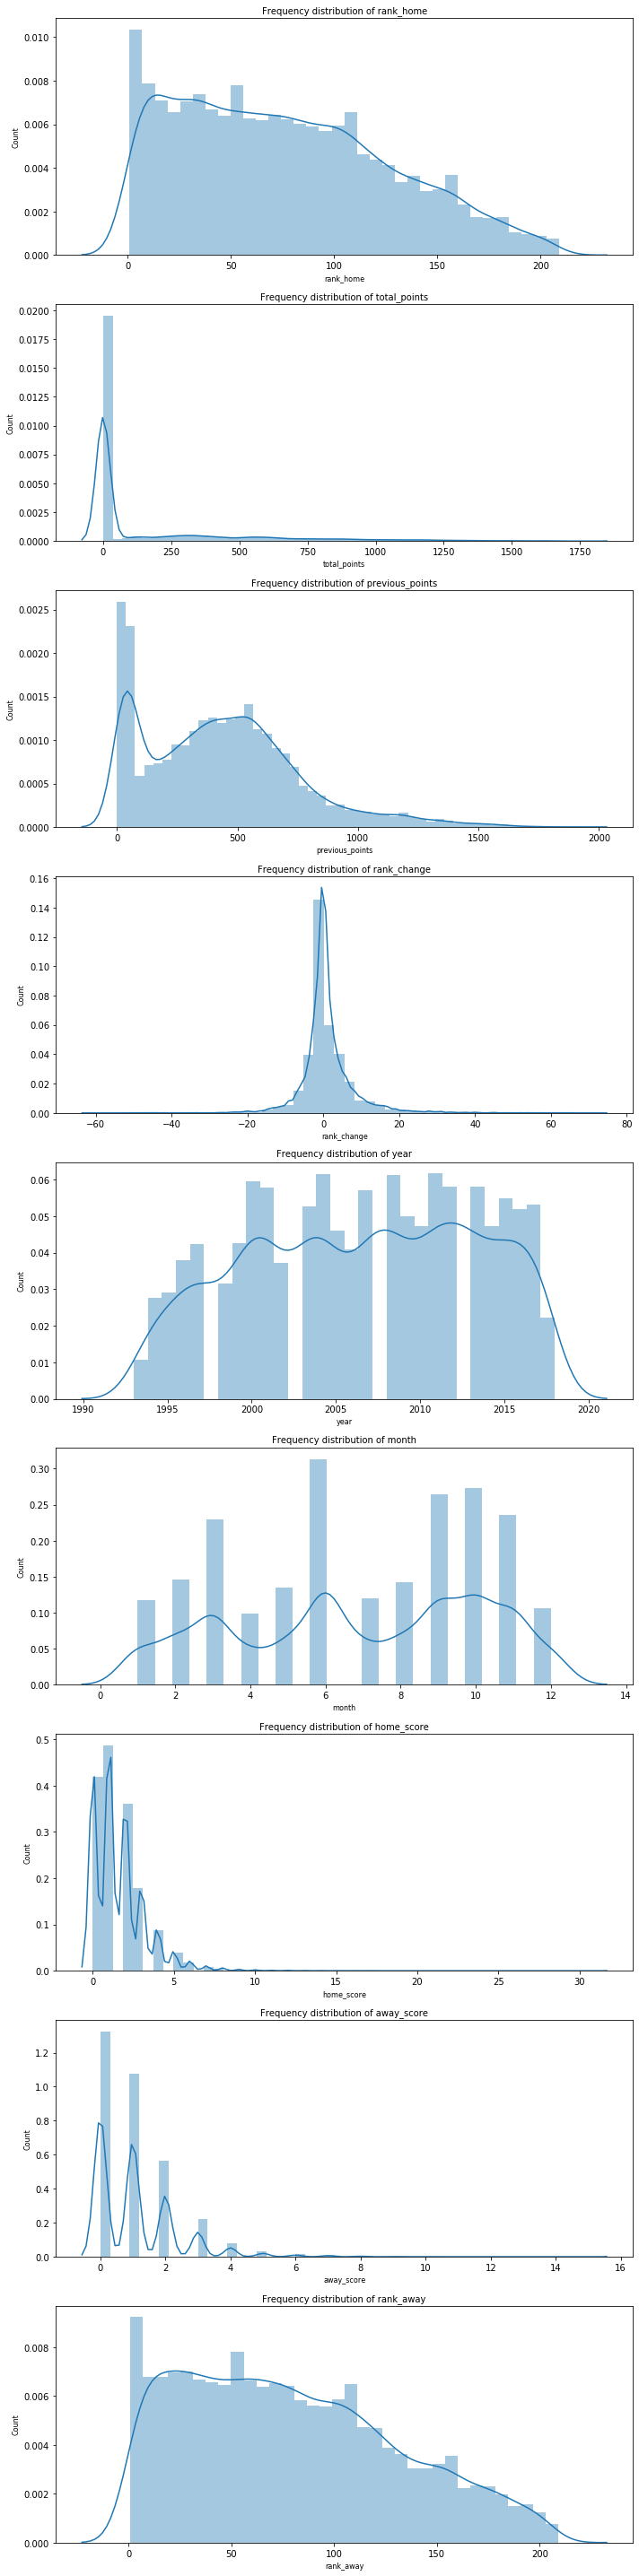

In [529]:
# Plotting distribution of numerical variables
col_names = ['rank_home', 'total_points', 'previous_points',
       'rank_change', 'year', 'month', 'home_score',
       'away_score', 'rank_away']
fig, ax = plt.subplots(len(col_names), figsize=(10,40))

for i, col_val in enumerate(col_names):

    sns.distplot(merged_df[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Frequency distribution of '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)
    
plt.tight_layout()
plt.show()



All columns are negatively skewed from rank_change which has an almost normal distribution and year which has a multimodal distribution while month column which has an almost normal distribution but its heavy-tailed.

#Bivariate Analysis

<function matplotlib.pyplot.show>

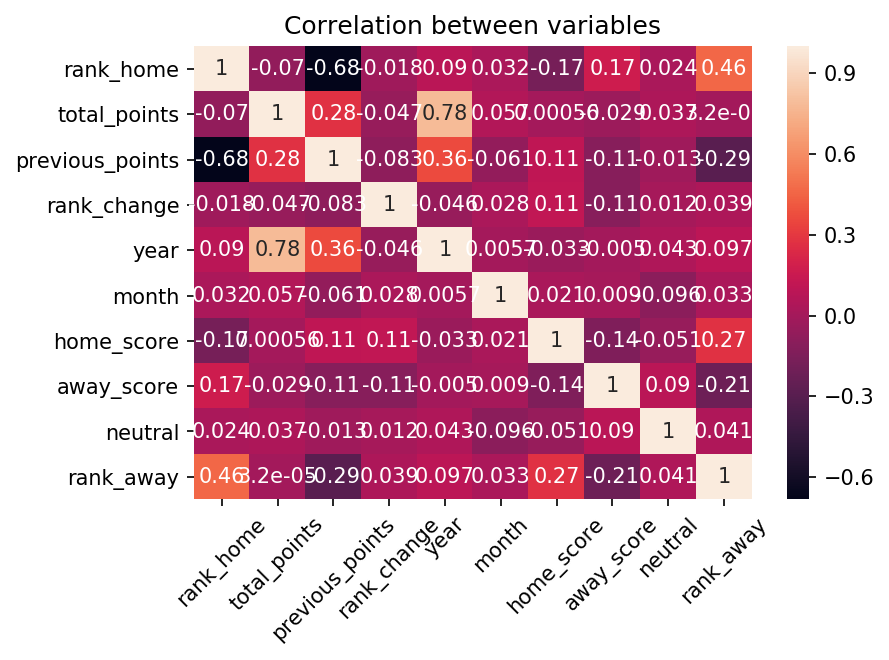

In [530]:
plt.figure(dpi=150)
cor=merged_df.corr(method = 'spearman')
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, annot = True)
plt.xticks( rotation=45)
plt.title('Correlation between variables')
plt.show

**Observations**

* 0.78 is the highes postive correlation and its between the year and the total points which is sensible considering with an increase in years the total points increase.
* -0.66 is the highest negative correlation and its between the rank_home and the previous points.

#Checking for outliers

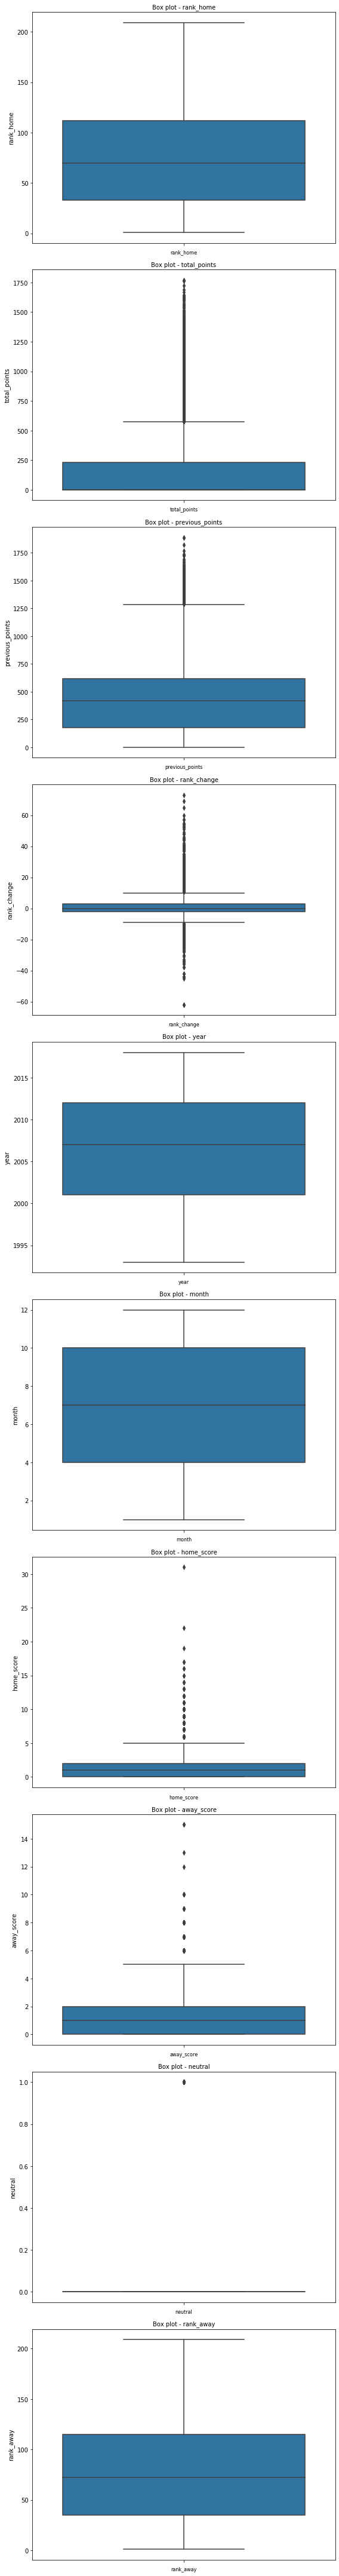

In [531]:
col_names = numeric_clmns = merged_df.dtypes[merged_df.dtypes != "object" ].index

fig, ax = plt.subplots(len(col_names), figsize=(8,60))

for i, col_val in enumerate(col_names):

    sns.boxplot(y=merged_df[col_val], ax=ax[i])
    ax[i].set_title('Box plot - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.tight_layout()
plt.show()

The outliers seen in the columns are legitimate and are useful in the modeling of our data.

#Feature engineering

Coming up with a results column that is the differnece between the home and away score


In [532]:
def get_score():
  overall_score = []
  merged_df['score_diff'] = merged_df['home_score'] - merged_df['away_score']
  for x in merged_df['score_diff']:
    if x>0:
      overall_score.append('win')
    elif x =='0':
      overall_score.append('draw')
    elif x<0:
      overall_score.append('loss')
    else:
      overall_score.append('none')
  merged_df['overall_score']= overall_score

get_score()
merged_df.head()

,rank_home,country,total_points,previous_points,rank_change,year,month,home_team,away_team,home_score,away_score,tournament,neutral,rank_away,score_diff,overall_score
0,4,Sweden,0.0,55,0,1993,8,Sweden,Switzerland,1,2,Friendly,False,3,-1,loss
1,4,Sweden,0.0,55,0,1993,8,Sweden,France,1,1,FIFA World Cup qualification,False,12,0,none
2,5,Argentina,0.0,51,5,1993,8,Argentina,Peru,2,1,FIFA World Cup qualification,False,70,1,win
5,19,Colombia,0.0,36,16,1993,8,Colombia,Peru,4,0,FIFA World Cup qualification,False,70,4,win
8,67,Paraguay,0.0,22,1,1993,8,Paraguay,Peru,2,1,FIFA World Cup qualification,False,70,1,win


In [0]:
#changing the nuetral and overall score columns into numerical data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()




In [0]:
le.fit(merged_df['overall_score'])
#le.fit(merged_df['neutral'])

merged_df['numerical_score'] = le.transform(merged_df['overall_score'])
# merged_df['nuetral_numerical'] = le.transform(merged_df['neutral'])

# merged_df.head()

In [0]:

le.fit(merged_df['neutral'])


merged_df['neutral_numerical'] = le.transform(merged_df['neutral'])



In [536]:
merged_df.head()

,rank_home,country,total_points,previous_points,rank_change,year,month,home_team,away_team,home_score,away_score,tournament,neutral,rank_away,score_diff,overall_score,numerical_score,neutral_numerical
0,4,Sweden,0.0,55,0,1993,8,Sweden,Switzerland,1,2,Friendly,False,3,-1,loss,0,0
1,4,Sweden,0.0,55,0,1993,8,Sweden,France,1,1,FIFA World Cup qualification,False,12,0,none,1,0
2,5,Argentina,0.0,51,5,1993,8,Argentina,Peru,2,1,FIFA World Cup qualification,False,70,1,win,2,0
5,19,Colombia,0.0,36,16,1993,8,Colombia,Peru,4,0,FIFA World Cup qualification,False,70,4,win,2,0
8,67,Paraguay,0.0,22,1,1993,8,Paraguay,Peru,2,1,FIFA World Cup qualification,False,70,1,win,2,0


#Linear regression


In [0]:
#Declaring out dependent and independent variables
x = merged_df[['rank_home','numerical_score','neutral_numerical', 'rank_away']]
y = merged_df[['home_score']]


In [538]:
#checking for null values
print(x.isnull().sum())
print(y.isnull().sum())

rank_home            0
numerical_score      0
neutral_numerical    0
rank_away            0
dtype: int64
home_score    0
dtype: int64


In [0]:

#splitting of the dataset into train and test set 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(x,y, test_size = 0.2,random_state = 0)

In [540]:
#fitting into a linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [541]:
#To get the y_intercept:
print(reg.intercept_)
#To get the slope of our line
print(reg.coef_)

[0.23171291]
[[-0.00459346  0.92641779 -0.0583063   0.00788753]]


In [542]:
#Getting our predictions
y_pred = reg.predict(x_test )
y_pred

array([[ 0.86575659],
       [ 1.17388333],
       [-0.21330555],
       ...,
       [-0.12189238],
       [ 2.51166111],
       [ 0.27142422]])

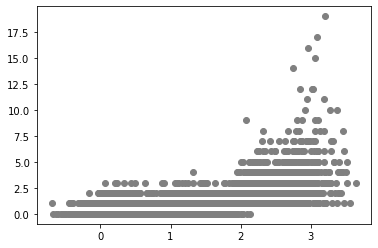

In [543]:
plt.scatter(y_pred, y_test,  color='gray')
plt.show()

In [544]:
#Determining the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

1.2885782587693015

#Logistic Regression

In [0]:
x = merged_df[['rank_home', 'rank_away', 'neutral_numerical']]
y = merged_df[['numerical_score']]

In [0]:
#splitting the dataset into train and test set 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state=25)

In [547]:
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression()
logistic_reg.fit(x_train, y_train)
training_score = logistic_reg.score(x_train, y_train)
test_score = logistic_reg.score(x_test, y_test)

print("Training set accuracy: ",(training_score))
print("Test set accuracy: ",(test_score))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training set accuracy:  0.5822816972982129
Test set accuracy:  0.5767634854771784


The accuracy of our logistic regresion:
* Test set accuracy: 0.5822816972982129
* Training set accuracy: 0.5767634854771784

#Polynormial regression

**Home team predictions**

In [0]:
a = merged_df['rank_home'].values.reshape(-1,1)
b = merged_df['home_score'].values

In [0]:
#splitting our dataset
x_train, x_test, y_train, y_test = train_test_split(a, b, test_size = 0.2, random_state=0)

In [550]:
#Fitting polynormial regression to our dataset
from sklearn.preprocessing import PolynomialFeatures
polreg = PolynomialFeatures(degree = 6)
poly = polreg.fit_transform(a)
poly_r = LinearRegression()
poly_r.fit(poly, b)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [551]:

# Checking the prediction
y_pred= poly_r.predict(poly)
y_pred


array([2.13606845, 2.13606845, 2.09795997, ..., 1.42718795, 1.43497975,
       1.41538502])

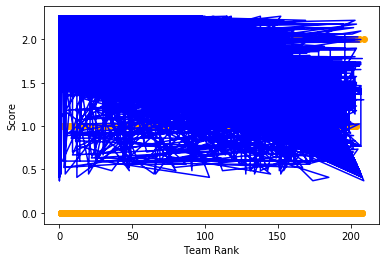

In [552]:
#a visualization of the Polynomial Regression results
plt.scatter(x.iloc[:,0], y.iloc[:,0], color='orange')
plt.plot(x, poly_r.predict(poly), color='blue')
plt.xlabel('Team Rank')
plt.ylabel('Score')
plt.show()

In [553]:
# calculating the RMSE to determine accuracy of the model
from sklearn.metrics import mean_squared_error
#
RMSE = np.sqrt(mean_squared_error(y, y_pred))
#
print(RMSE)

0.9171021108905066


**Away team predictions**

In [0]:
c = merged_df['rank_away'].values.reshape(-1,1)
d = merged_df['away_score'].values

In [0]:
#splitting our dataset
x_train, x_test, y_train, y_test = train_test_split(c, d, test_size = 0.2, random_state=0)

In [556]:
from sklearn.preprocessing import PolynomialFeatures
polreg = PolynomialFeatures(degree = 6)
poly = polreg.fit_transform(c)
poly_r = LinearRegression()
poly_r.fit(poly, d)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

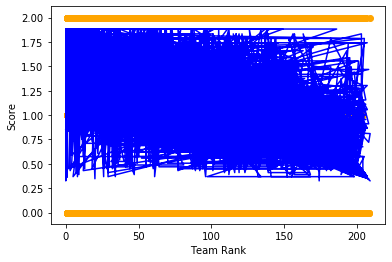

In [557]:
# Checking the prediction
y_pred= poly_r.predict(poly)
y_pred
#a visualization of the Polynomial Regression results
plt.scatter(x.iloc[:,0], y.iloc[:,0], color='orange')
plt.plot(x, poly_r.predict(poly), color='blue')
plt.xlabel('Team Rank')
plt.ylabel('Score')
plt.show()

In [558]:
# calculating the RMSE to determine accuracy of the model
from sklearn.metrics import mean_squared_error
#
RMSE = np.sqrt(mean_squared_error(y, y_pred))
#
print(RMSE)

0.9600334934332885


# Conclussion


Polynormial RMSE scores:
* 0.9600334934332885(away)
* 0.9171021108905066(home)

Linear Regression RMSE:
* 1.2885782587693015

Logistic Regresion
* Test set accuracy: 0.5822816972982129
* Training set accuracy: 0.5767634854771784

Since all our RMSE from linear and polynormial regression are lower than 1.0, we can say that our models have moderate accuracy and will need more columns to be increase their accuracy.